In [1]:
import neutromeratio
from openmmtools.constants import kB
from simtk import unit
import numpy as np
import pickle
import mdtraj as md
import torchani
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))

# specify the system you want to simulate
name = 'molDWRow_298'
#name = 'molDWRow_37'
#name = 'molDWRow_45'
#name = 'molDWRow_160'
#name = 'molDWRow_590'


from_mol_tautomer_idx = 1
to_mol_tautomer_idx = 2


t1_smiles = exp_results[name]['t1-smiles']
t2_smiles = exp_results[name]['t2-smiles']

# generate both rdkit mol
mols = { 't1' : neutromeratio.generate_rdkit_mol(t1_smiles), 't2' : neutromeratio.generate_rdkit_mol(t2_smiles) }
from_mol = mols[f"t{from_mol_tautomer_idx}"]
to_mol = mols[f"t{to_mol_tautomer_idx}"]
ani_input = neutromeratio.from_mol_to_ani_input(from_mol)

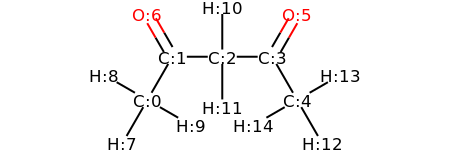

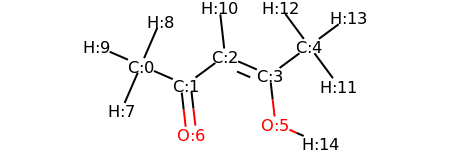

In [3]:
neutromeratio.display_mol(mols['t1'])
neutromeratio.display_mol(mols['t2'])

[utils.py:48 - get_donor_atom_idx()] Index of atom that moves: 11.
[utils.py:54 - get_donor_atom_idx()] Index of atom that donates hydrogen: 2
[utils.py:72 - get_donor_atom_idx()] Index of atom that accepts hydrogen: 5


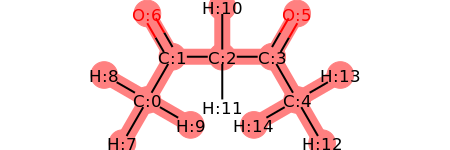

In [4]:
# extract hydrogen donor idx and hydrogen idx for from_mol
tautomer_transformation = neutromeratio.get_donor_atom_idx(from_mol, to_mol)
platform = 'cpu'
device = torch.device(platform)
model = neutromeratio.ani.LinearAlchemicalANI(alchemical_atoms=tautomer_transformation['hydrogen_idx'])
model = model.to(device)
torch.set_num_threads(2)

In [5]:
energy_function = neutromeratio.ANI1_force_and_energy(device = device,
                                          model = model,
                                          atom_list = ani_input['atom_list'],
                                          platform = platform,
                                          tautomer_transformation = tautomer_transformation,
                                          bond_restraint=True)

langevin = neutromeratio.LangevinDynamics(atom_list = ani_input['atom_list'],
                            temperature = 300*unit.kelvin,
                            force = energy_function)

hydrogen_mover = neutromeratio.NonequilibriumMC(donor_idx = tautomer_transformation['donor_idx'], 
                                       hydrogen_idx = tautomer_transformation['hydrogen_idx'], 
                                       acceptor_idx = tautomer_transformation['acceptor_idx'], 
                                       atom_list = ani_input['atom_list'], 
                                       energy_function = energy_function,
                                       langevin_dynamics= langevin)



# initial conditions: coordinates from example were given in units of angstroms   
x0 = np.array(ani_input['coord_list']) * unit.angstrom

print(f"Hydrogen {hydrogen_mover.hydrogen_idx} is moved from atom-idx {hydrogen_mover.donor_idx} to atom-idx {hydrogen_mover.acceptor_idx}.")

Hydrogen 11 is moved from atom-idx 2 to atom-idx 5.


In [13]:
# number of time steps
nr_of_mc_trials = 100


# generating mdtraj traj object
topology = md.load(f"../data/structures/{name}/{name}_tautomer_{from_mol_tautomer_idx}.pdb").topology

# run MD and MC protocoll
work, traj = hydrogen_mover.performe_md_mc_protocoll(x0 = x0,
                             nr_of_mc_trials = nr_of_mc_trials)    

# save trajectory
ani_traj = md.Trajectory(traj, topology)
ani_traj.save(f"../data/md_mc_sampling/{name}/{name}_nonequilibrium_t{from_mol_tautomer_idx}_anicxx.dcd")



[mcmc.py:226 - performe_md_mc_protocoll()] Decoupling hydrogen ...
100%|██████████| 50/50 [02:14<00:00,  3.06s/it]
[mcmc.py:239 - performe_md_mc_protocoll()] Moving hydrogen ...
[mcmc.py:245 - performe_md_mc_protocoll()] Recoupling hydrogen ...
100%|██████████| 50/50 [02:37<00:00,  3.67s/it]


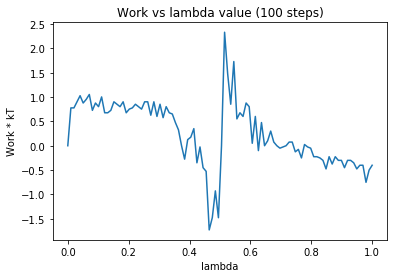

In [15]:
plt.plot(np.linspace(0, 1, len(work)), work)
plt.xlabel('lambda')
plt.ylabel('Work * kT')
plt.title('Work vs lambda value ({} steps)'.format(len(work)))
plt.show()

In [16]:
print(sum(work))

25.357391471691496


In [17]:
top_file = f"../data/structures/{name}/{name}_tautomer_{from_mol_tautomer_idx}.pdb",
traj_files = [f"../data/md_mc_sampling/{name}/{name}_nonequilibrium_t{from_mol_tautomer_idx}_anicxx.dcd"]


In [18]:
neutromeratio.utils.generate_nglview_object(
    top_file=top_file,
    traj_files=traj_files
)

NGLWidget(count=5100)

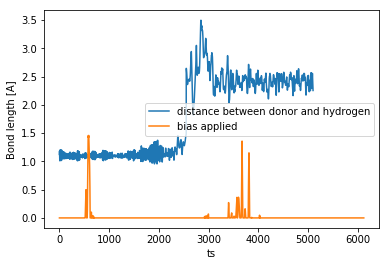

1.7999327672111392
0.6913693916265874


In [19]:
import matplotlib.pyplot as plt


distance_list = []
for x in traj:
    distance_list.append(neutromeratio.constants.nm_to_angstroms * np.linalg.norm(x[tautomer_transformation['hydrogen_idx']] - x[tautomer_transformation['donor_idx']]))

    
plt.plot(distance_list, label='distance between donor and hydrogen')
plt.plot(energy_function.bias, label='bias applied')
plt.xlabel('ts')
plt.ylabel('Bond length [A]')
#plt.axhline(y=0.86, color='r', linestyle='-',)
#plt.axhline(y=1.06, color='r', linestyle='-',)
plt.legend()
plt.show()

print(np.mean(distance_list))
print(np.std(distance_list))
